In [35]:
import gymnasium as gym
import torch
import torch.nn as nn
from torch.nn import functional as F

from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
DEVICE

device(type='cuda')

1. Модель Исполнитель и Критик на общем слое

In [37]:
class ActorCriticModel(nn.Module):
    # слои модели   
    def __init__(self, n_input, n_output, n_hidden):
        super(ActorCriticModel, self).__init__()
        self.hidden = nn.Linear(n_input, n_hidden)
        self.actor_action = nn.Linear(n_hidden, n_output)
        self.critic_value = nn.Linear(n_hidden, 1)

    # способ обучения модели
    def forward(self, s):
        s = self.hidden(s)
        s = F.relu(s)
        actions = self.actor_action(s)
        values = self.critic_value(s)
        return actions, values    

3. Функция политики выбора действия

In [38]:
# Получить у модели Исполнителя действие максимальной вероятности без обучния
def policy(agent, state):
    with torch.no_grad():
        state = torch.tensor(state, device=DEVICE)
        actions, _ = agent(state)
        probs = F.softmax(actions, dim=-1)
        a = torch.multinomial(probs, num_samples=1)
        return a.tolist()[0]

4. Функция обучения модели

In [39]:
def a2c_learning(env, agent, optimizer, scheduler, n_episodes, total_reward_episode, gamma=0.9):



    # для каждой эпохи
    for n in tqdm(range(n_episodes)):

        # сбросить среду
        state,_ = env.reset()
        # создать создать списки стартового состояния, действий и наград за действия для каждого шага
        states = []
        actions = []
        rewards = []

        is_step = True
        # запуск среды
        while is_step:
            # получить действие от Испольнителя (без обученния)
            action = policy(agent, state)
            # запустить среду с этим действием и получить ее результирующее состояние
            next_state, reward, is_done, is_break, _ = env.step(action)
            # сохранить в списки стартового состояния, действие и награду за действие
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state
            is_step = not is_done and not is_break

        states = torch.tensor(states, dtype=torch.float, requires_grad=True, device=DEVICE)
        actions = torch.tensor(actions, dtype=torch.int64, device=DEVICE)

        # из списка наград за отдельное действие получить список сумм нагдад за все действия до текущего в списке
        # список Полных наград для кажного состояния среды
        cum_rewards = []
        Gt = 0
        for reward in rewards[::-1]:
            Gt += gamma * reward
            cum_rewards.append(Gt)
        cum_rewards = torch.tensor(cum_rewards[::-1], dtype=torch.float, requires_grad=True, device=DEVICE)

        # Обучение модели 
        # обучить модель на списке стартового состояния
        q_values, values = agent(states)
        values = values.squeeze(dim=1)

        # получение ценности состояний из оценок Критика и списка полных вознаграждений (без обучения)
        advantages = cum_rewards - values

        # обнулить градиенты
        optimizer.zero_grad()
        # считаем лосс из оценок Критика () и списка полных вознаграждений
        vf_loss = F.mse_loss(values, cum_rewards, reduction="none")
        # считаем лосс из оценок Исполнителя (действия) и списка осуществленных действий (логарифм вероятностей изменения состояний)
        log_probs = -F.cross_entropy(q_values, actions, reduction="none")
        # считаем сумму произведений отрицательных логорифмов потери на ценность состояний
        pi_loss = -log_probs * advantages
        # считаем сумму общих потерь
        loss = vf_loss.sum() + pi_loss.sum()
        # делаем шаг лосс в обратном направлении
        loss.backward()
        # делаем шаг оптимизатора
        optimizer.step()

        total_reward_episode[n] = sum(rewards)

        if total_reward_episode[n] > 40:
            print(n, total_reward_episode[n])
            scheduler.step()



5. Среда обучения 

In [40]:
env = gym.make('LunarLander-v2')

6. Создание моделей с заданными параметрами

In [41]:
# параемры моделей
# количество входящих парамеров
n_state = env.observation_space.shape[0]
# количество выходящих парамеров исполинтельной сети
n_action = env.action_space.n
# количество скрытых нейронов
n_hidden = 128
# скорость обучения
LR = 0.0001


# 1. Задать модель - nn.Module
agent = ActorCriticModel(n_state, n_action, n_hidden).to(DEVICE)

# 2. Задать оптимизатор - torch.optim.NAME_OF_OPTIM
optimizer = torch.optim.Adam(agent.parameters(), lr=LR)

# 3. Задать функцию скорости обучения - torch.optim.lr_scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


7. Запуск обучения

In [42]:
# общее количество эпох
n_episodes = 1500
# коэффициент обесценивания 
gamma = 0.99
# общая награда в каждом эпизоде
total_reward_episode = np.zeros(n_episodes)

# запуск функции обучения
a2c_learning(env, agent, optimizer, scheduler, n_episodes, total_reward_episode, gamma)

 27%|██▋       | 400/1500 [00:36<03:09,  5.80it/s]

397 64.03879655350013


 54%|█████▎    | 805/1500 [01:11<01:00, 11.48it/s]

803 44.81132799662592


 69%|██████▊   | 1029/1500 [01:29<00:40, 11.56it/s]

1026 46.714968038190364


 74%|███████▍  | 1107/1500 [01:36<01:01,  6.35it/s]

1103 55.1957559578909


100%|██████████| 1500/1500 [02:09<00:00, 11.54it/s]


8. Результаты

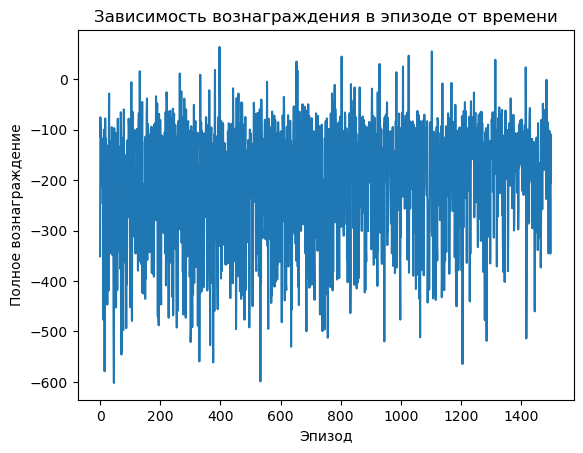

In [44]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()